In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os

from scipy.signal import butter, lfilter
from scipy.signal import convolve

import utilities

import importlib
def reimport_module(module_name):
    """
    Reimports the specified Python module.
    
    Args:
    module_name (module): The module to be reimported, typically passed as a variable.
    
    Returns:
    module: The reloaded module.
    """
    try:
        # Reload the already imported module
        reloaded_module = importlib.reload(module_name)
        print(f"Module {module_name.__name__} reloaded successfully.")
        return reloaded_module
    except Exception as e:
        print(f"Failed to reload module: {e}")

reimport_module(utilities)

Module utilities reloaded successfully.


<module 'utilities' from '/glade/work/wchapman/DA_ML/CESML_AI/Paper_Figures/CMJO_Diagnostics_Tool/utilities.py'>

## Vars In

In [11]:
twStrt = '1979-10-01'
twLast = '1993-12-31'

cwStrt = '1979-11-01'
cwLast = '2001-05-31'

dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/climo/'
f_precip_in = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.PRECT.anomalies.1979010100000-1990123100000.nc'
var_name_precip = 'PRECT'

f_u_in = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.Q.anomalies.1979010100000-1990123100000.nc'
var_name_u = 'Q'

dir_out = f'{dir_in}/mjo_diag/'
# Check if the directory exists
if not os.path.exists(dir_out):
    # Create the directory
    os.makedirs(dir_out)
    print(f"Directory {dir_out} created.")

save_Fig_out = f'{dir_out}/{f_precip_in.split(var_name_precip)[0]}Lagged_MJO_TS_{var_name_precip}_{var_name_u}.png'
print(f'saving figure to {save_Fig_out}')
save_nc_out = f'{dir_out}/{f_precip_in.split(var_name_precip)[0]}Lagged_MJO_TS_{var_name_precip}_{var_name_u}.nc'
print(f'saving figure to {save_nc_out}')

saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/climo//mjo_diag//f.e.FTORCHmjo_fullCNN_DT.cam.h1.Lagged_MJO_TS_PRECT_Q.png
saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/climo//mjo_diag//f.e.FTORCHmjo_fullCNN_DT.cam.h1.Lagged_MJO_TS_PRECT_Q.nc


## Region Setting:

In [12]:
lat_bounds_IO = slice(-10, 5)
lon_bounds_IO = slice(75, 100)
lat_bounds_global = slice(-30, 30)
latns = slice(-10, 10)   
lonlr = slice(80, 100)

# Define bandpass frequency limits
f_low = 100  # Corresponds to  days period
f_high = 20   # Corresponds to 20 days period
maxlag = 30

## Open Files

In [13]:
# precip: 
file_path_precip = os.path.join(dir_in, f_precip_in)  # Join the directory and file name
DS_precip = xr.open_dataset(file_path_precip)

# u850: 
file_path_u = os.path.join(dir_in, f_u_in)  # Join the directory and file name
DS_u = xr.open_dataset(file_path_u)

#create cosine latitude weighting: 
weights = np.cos(np.deg2rad(DS_u.lat))

## Precip Indian Ocean:

In [14]:
PIO = (DS_precip*weights).sel(lat = lat_bounds_IO, lon = lon_bounds_IO).mean(['lat','lon'])

##fft this time series: 
PIO_arr = np.array(PIO[var_name_precip])
mean_value = np.nanmean(PIO_arr)
PIO_arr[np.isnan(PIO_arr)] = mean_value
PIO_f = utilities.bandpass_filter_via_fft_1d(PIO_arr, f_high, f_low, sampling_interval=1)
PIO['PRECT_f'] = copy.deepcopy(PIO[var_name_precip])
PIO['PRECT_df'] = copy.deepcopy(PIO[var_name_precip])

PIO['PRECT_f'][:] = PIO_f
PIO['PRECT_df'][:] = utilities.detrend(PIO_f)

PIO['PRECT_f'].attrs = DS_precip[var_name_precip].attrs
PIO['PRECT_f'].attrs['long_name'] = 'Total precipitaption rate averaged over IO fft filtered'
PIO['PRECT_df'].attrs = DS_precip[var_name_precip].attrs
PIO['PRECT_df'].attrs['long_name'] = 'Total precipitaption rate averaged over IO, detrended, fft filtered'
PIO[var_name_precip].attrs = DS_precip[var_name_precip].attrs
PIO[var_name_precip].attrs['long_name'] = 'Total precipitaption rate averaged over IO'

## Lat/Lon averages of U and P

In [15]:
# create a LAT average
DS_u['U_timeLon'] = xr.zeros_like((DS_u[var_name_u]*weights).sel(lat=latns).mean('lat'))
DS_u['U_timeLon'][:] = copy.deepcopy((DS_u[var_name_u]*weights).sel(lat=latns).mean('lat'))
DS_u['U_timeLon_f'] = copy.deepcopy(DS_u['U_timeLon'])
DS_u['U_timeLon_f'][:] = utilities.bandpass_filter_via_fft_2d(np.array(DS_u['U_timeLon']), f_high, f_low, sampling_interval=1)

DS_precip['PRECT_timeLon'] = xr.zeros_like((DS_precip[var_name_precip]*weights).sel(lat=latns).mean('lat'))
DS_precip['PRECT_timeLon'][:] = copy.deepcopy((DS_precip[var_name_precip]*weights).sel(lat=latns).mean('lat'))
DS_precip['PRECT_timeLon_f'] = copy.deepcopy(DS_precip['PRECT_timeLon'])
DS_precip['PRECT_timeLon_f'][:] = utilities.bandpass_filter_via_fft_2d(np.array(DS_precip['PRECT_timeLon']), f_high, f_low, sampling_interval=1)

# create a LON average
DS_u_lonavg = copy.deepcopy((DS_u[var_name_u]*weights).sel(lat=lat_bounds_global,lon=lonlr).mean('lon')).to_dataset(name='U_timeLat')
DS_u_lonavg['U_timeLat_f'] = copy.deepcopy(DS_u_lonavg['U_timeLat'])
DS_u_lonavg['U_timeLat_f'][:] = utilities.bandpass_filter_via_fft_2d(np.array(DS_u_lonavg['U_timeLat']), f_high, f_low, sampling_interval=1)

DS_precip_lonavg = copy.deepcopy((DS_precip[var_name_precip]*weights).sel(lat=lat_bounds_global,lon=lonlr).mean('lon')).to_dataset(name='PRECT_timeLat')
DS_precip_lonavg['PRECT_timeLat_f'] = copy.deepcopy(DS_precip_lonavg['PRECT_timeLat'])
DS_precip_lonavg['PRECT_timeLat_f'][:] = utilities.bandpass_filter_via_fft_2d(np.array(DS_precip_lonavg['PRECT_timeLat']), f_high, f_low, sampling_interval=1)

ValueError: operands could not be broadcast together with shapes (4380,288) (4380,) 

## Lagged matrix Lat average:

In [ ]:
# Calculate lagged correlations with a broader range of lags
seasons_do = np.unique(DS_u['time.year'])

size_lons = DS_u['U_timeLon_f'].sel(time=slice('1979-11-01','1980-05-31')).shape[1]
xcorr_val_U_timeLon_f = np.zeros([len(seasons_do)-2,size_lons,(maxlag*2)+1])
xcorr_val_P_timeLon_f = np.zeros([len(seasons_do)-2,size_lons,(maxlag*2)+1])

for ss, sd in enumerate(seasons_do[:-2]):
    print(sd)
    x = pd.Series(PIO.sel(time=slice(f'{sd}-11-01',f'{sd+1}-05-31'))['PRECT_f'][:])
    for vv in range(size_lons):
        y = pd.Series(DS_u['U_timeLon_f'].sel(time=slice(f'{sd}-11-01',f'{sd+1}-05-31'))[:,vv])
        corrs = utilities.lagged_correlation(y, x, maxlag)
        xcorr_val_U_timeLon_f[ss,vv,:] = np.array(list(corrs.values()))
    
        y = pd.Series(DS_precip['PRECT_timeLon_f'].sel(time=slice(f'{sd}-11-01',f'{sd+1}-05-31'))[:,vv])
        corrs = utilities.lagged_correlation(y, x, maxlag)
        xcorr_val_P_timeLon_f[ss,vv,:] = np.array(list(corrs.values()))
lags = list(corrs.keys())

In [ ]:
size_lats = len(DS_u_lonavg['lat'])

xcorr_val_U_timeLat_f = np.zeros([len(seasons_do)-2,size_lats,(maxlag*2)+1])
xcorr_val_P_timeLat_f = np.zeros([len(seasons_do)-2,size_lats,(maxlag*2)+1])

# Calculate lagged correlations with a broader range of lags
seasons_do = np.unique(DS_u_lonavg['time.year'])

size_lons = DS_u_lonavg['U_timeLat_f'].sel(time=slice('1979-11-01','1980-05-31')).shape[1]
xcorr_val_U_timeLat_f = np.zeros([len(seasons_do)-2,size_lats,(maxlag*2)+1])
xcorr_val_P_timeLat_f = np.zeros([len(seasons_do)-2,size_lats,(maxlag*2)+1])

for ss, sd in enumerate(seasons_do[:-2]):
    print(sd)
    x = pd.Series(PIO.sel(time=slice(f'{sd}-11-01',f'{sd+1}-05-31'))['PRECT_f'][:])
    for vv in range(size_lats):
        y = pd.Series(DS_u_lonavg['U_timeLat_f'].sel(time=slice(f'{sd}-11-01',f'{sd+1}-05-31'))[:,vv])
        corrs = utilities.lagged_correlation(y, x, maxlag)
        xcorr_val_U_timeLat_f[ss,vv,:] = np.array(list(corrs.values()))
    
        y = pd.Series(DS_precip_lonavg['PRECT_timeLat_f'].sel(time=slice(f'{sd}-11-01',f'{sd+1}-05-31'))[:,vv])
        corrs = utilities.lagged_correlation(y, x, maxlag)
        xcorr_val_P_timeLat_f[ss,vv,:] = np.array(list(corrs.values()))

## Colormap

In [ ]:
# define the colormap
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(1)
# make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)

for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]

cmap.N
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
clevels = np.arange(-1.0,1.05,0.05)
contlevels = np.arange(-1,1.1,0.1)
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
cmap.set_under([0.3, 0.00, 0.1, 1.0])
cmap.set_over('k')

In [ ]:
# Assuming that the necessary data and variables like clevels, cmap, norm, etc., are already defined
# Create a figure with two subplots (one for each variable) and share a single colorbar
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

plotter = np.mean((xcorr_val_P_timeLon_f[:,:,:]),axis=0).T
plotterC = np.mean((xcorr_val_U_timeLon_f[:,:,:]),axis=0).T

# Plot for the first dataset
ff1 = ax1.contourf(DS_u['lon'], lags, plotter, levels=clevels, cmap=cmap, norm=norm, extend='both')
clr1 = ax1.contour(DS_u['lon'], lags, plotterC, levels=contlevels, colors='k', alpha=0.3)
ax1.clabel(clr1, colors='k', fontsize=12, inline=True, fmt='%1.1f')
ax1.grid(True, alpha=0.2)
ax1.set_xlabel('Longitude', fontsize=15)
ax1.set_ylabel('Lags', fontsize=15)
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.tick_params(labelsize=15) 
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_ylim([-25,25])

# Plot for the second dataset
plotter = np.mean((xcorr_val_P_timeLat_f[:,:,:]),axis=0).T
plotterC = np.mean((xcorr_val_U_timeLat_f[:,:,:]),axis=0).T

ff2 = ax2.contourf(DS_u_lonavg['lat'], lags, plotter, levels=clevels, cmap=cmap, norm=norm, extend='both')
clr2 = ax2.contour(DS_u_lonavg['lat'], lags, plotterC, levels=contlevels, colors='k', alpha=0.3)
ax2.clabel(clr2, colors='k', fontsize=12, inline=True, fmt='%1.1f')
ax2.grid(True, alpha=0.2)
ax2.set_xlabel('Latitude', fontsize=15)
ax2.set_ylabel('Lags', fontsize=15)
lat_formatter = LatitudeFormatter(number_format='.0f')
ax2.tick_params(labelsize=15) 
ax2.xaxis.set_major_formatter(lat_formatter)
ax2.set_ylim([-25,25])

# Create a colorbar on the right side of the plot
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])  # Adjust the colorbar position
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
cbar_ax.set_ylabel('Correlation', size=15)
cb.ax.tick_params(labelsize=15)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
# plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()

## Save Out

In [41]:
lags = np.array(lags)
lats = DS_u_lonavg['lat']
lons = DS_u['lon']

# Create xarray DataArrays
data_lat = xr.DataArray(np.mean((xcorr_val_P_timeLat_f[:,:,:]),axis=0), dims=['lat', 'lags'], coords={'lat': lats, 'lags': lags},
                        attrs={'long_name': 'xcorr Precip lats (or defined variable)',
                               'description': 'lagged correlation of precipatation to the IO region'})

data_lat_u = xr.DataArray(np.mean((xcorr_val_U_timeLat_f[:,:,:]),axis=0), dims=['lat', 'lags'], coords={'lat': lats, 'lags': lags},
                        attrs={'long_name': 'xcorr U lats (or defined variable)',
                               'description': 'lagged correlation of precipatation to the IO region'})

data_lon = xr.DataArray(np.mean((xcorr_val_P_timeLon_f[:,:,:]),axis=0), dims=['lon', 'lags'], coords={'lon': lons, 'lags': lags},
                        attrs={'long_name': 'xcorr Precip lons (or defined variable)',
                               'description': 'lagged correlation of precipatation to the IO region'})

data_lon_u = xr.DataArray(np.mean((xcorr_val_U_timeLon_f[:,:,:]),axis=0), dims=['lon', 'lags'], coords={'lon': lons, 'lags': lags},
                        attrs={'long_name': 'xcorr U lons (or defined variable)',
                               'description': 'lagged correlation of precipatation to the IO region'})


# Create Dataset
ds = xr.Dataset({
    'xcorr_P_timeLat': data_lat,
    'xcorr_P_timeLon': data_lon,
    'xcorr_U_timeLat': data_lat_u,
    'xcorr_U_timeLon': data_lon_u,
    
})

# Adding metadata to the dataset
ds.attrs['title'] = 'Wchapman MJO diagnostics package wchapman@ucar.edu'
ds.attrs['institution'] = 'NCAR'
ds.attrs['source'] = 'Whatever the fuck you put in.'
ds.attrs['history'] = 'Created on ' + np.datetime_as_string(np.datetime64('now'), unit='D')
ds.attrs['comment'] = '15S-15N lag correlation of 20-100 day filtered precipitation in the Indian Ocean with precipitation and 850-mb zonal wind (contours) at all other longitude/latitude'

ds.to_netcdf(save_nc_out)

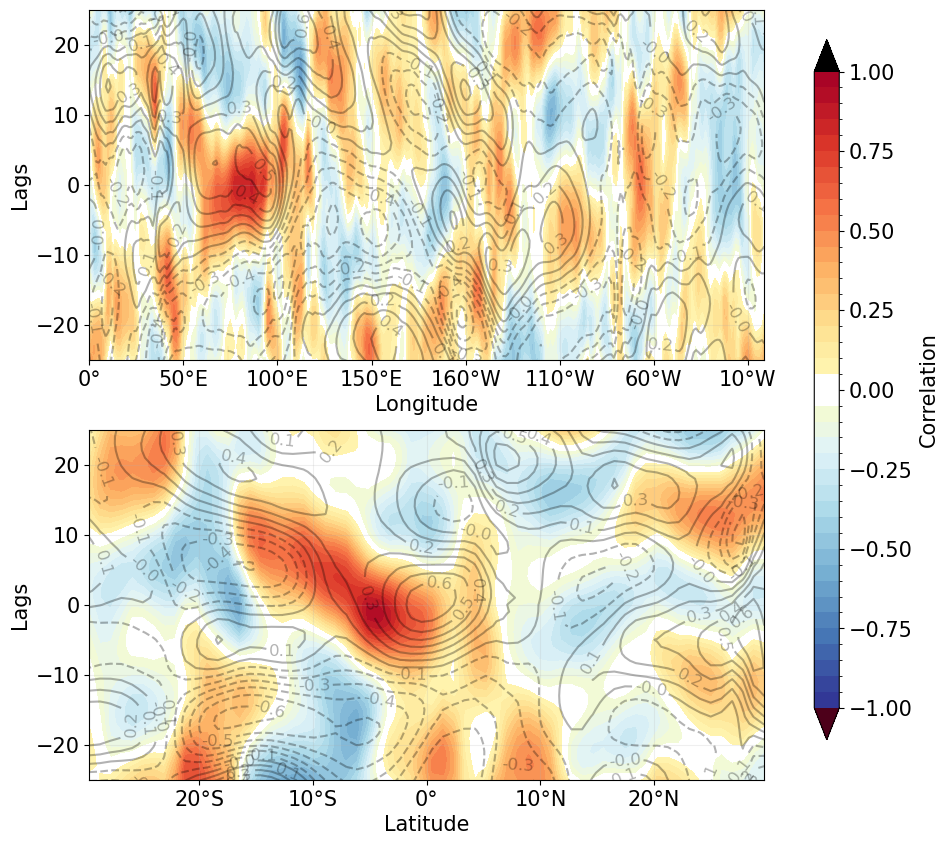

In [39]:
nummy=12
# Assuming that the necessary data and variables like clevels, cmap, norm, etc., are already defined
# Create a figure with two subplots (one for each variable) and share a single colorbar
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

plotter = ((xcorr_val_P_timeLon_f[nummy,:,:]).squeeze()).T
plotterC = ((xcorr_val_U_timeLon_f[nummy,:,:]).squeeze()).T

# Plot for the first dataset
ff1 = ax1.contourf(DS_u['lon'], lags, plotter, levels=clevels, cmap=cmap, norm=norm, extend='both')
clr1 = ax1.contour(DS_u['lon'], lags, plotterC, levels=contlevels, colors='k', alpha=0.3)
ax1.clabel(clr1, colors='k', fontsize=12, inline=True, fmt='%1.1f')
ax1.grid(True, alpha=0.2)
ax1.set_xlabel('Longitude', fontsize=15)
ax1.set_ylabel('Lags', fontsize=15)
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.tick_params(labelsize=15) 
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_ylim([-25,25])

# Plot for the second dataset
plotter = ((xcorr_val_P_timeLat_f[nummy,:,:]).squeeze()).T
plotterC = ((xcorr_val_U_timeLat_f[nummy,:,:]).squeeze()).T

ff2 = ax2.contourf(DS_u_lonavg['lat'], lags, plotter, levels=clevels, cmap=cmap, norm=norm, extend='both')
clr2 = ax2.contour(DS_u_lonavg['lat'], lags, plotterC, levels=contlevels, colors='k', alpha=0.3)
ax2.clabel(clr2, colors='k', fontsize=12, inline=True, fmt='%1.1f')
ax2.grid(True, alpha=0.2)
ax2.set_xlabel('Latitude', fontsize=15)
ax2.set_ylabel('Lags', fontsize=15)
lat_formatter = LatitudeFormatter(number_format='.0f')
ax2.tick_params(labelsize=15) 
ax2.xaxis.set_major_formatter(lat_formatter)
ax2.set_ylim([-25,25])

# Create a colorbar on the right side of the plot
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])  # Adjust the colorbar position
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
cbar_ax.set_ylabel('Correlation', size=15)
cb.ax.tick_params(labelsize=15)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
# plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()

In [ ]:
nummy = 12

# Assuming that the necessary data and variables like clevels, cmap, norm, etc., are already defined
# Create a figure with two subplots (one for each variable) and share a single colorbar
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
plotter = (xcorr_val_P_timeLon_f[nummy,:,:].squeeze()).T
plotterC = (xcorr_val_U_timeLon_f[nummy,:,:].squeeze()).T

# Plot for the first dataset
ff1 = ax1.contourf(DS_u['lon'], lags, plotter, levels=clevels, cmap=cmap, norm=norm, extend='both')
clr1 = ax1.contour(DS_u['lon'], lags, plotterC, levels=contlevels, colors='k', alpha=0.3)
ax1.clabel(clr1, colors='k', fontsize=12, inline=True, fmt='%1.1f')
ax1.grid(True, alpha=0.2)
ax1.set_xlabel('Longitude', fontsize=15)
ax1.set_ylabel('Lags', fontsize=15)
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.tick_params(labelsize=15) 
ax1.xaxis.set_major_formatter(lon_formatter)


# Plot for the second dataset
plotter = (xcorr_val_P_timeLat_f[nummy,:,:].squeeze()).T
plotterC = (xcorr_val_U_timeLat_f[nummy,:,:].squeeze()).T

ff2 = ax2.contourf(DS_u_lonavg['lat'], lags, plotter, levels=clevels, cmap=cmap, norm=norm, extend='both')
clr2 = ax2.contour(DS_u_lonavg['lat'], lags, plotterC, levels=contlevels, colors='k', alpha=0.3)
ax2.clabel(clr2, colors='k', fontsize=12, inline=True, fmt='%1.1f')
ax2.grid(True, alpha=0.2)
ax2.set_xlabel('Latitude', fontsize=15)
ax2.set_ylabel('Lags', fontsize=15)
lat_formatter = LatitudeFormatter(number_format='.0f')
ax2.tick_params(labelsize=15) 
ax2.xaxis.set_major_formatter(lat_formatter)

# Create a colorbar on the right side of the plot
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])  # Adjust the colorbar position
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
cbar_ax.set_ylabel('Correlation', size=15)
cb.ax.tick_params(labelsize=15)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
# plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()

# TESTING BELOW

## Here is a demo:

In [ ]:
cycles = np.array([1, 3, 5, 10, 18 ,19 ,30])
# Adjust cycles_2 to be within the bandpass range
cycles_2 = np.array([ 5, 10, 18 ])  # Days converted to frequencies

years_do = 10
sickos = utilities.generate_time_series(cycles, years_do)
sickos_2 = utilities.generate_time_series(cycles_2, years_do)

##fft this time series: 
# Define bandpass frequency limits
f_low = 100  # Corresponds to  days period
f_high = 20   # Corresponds to 20 days period
filtered_data = utilities.bandpass_filter_via_fft_1d(sickos, f_high, f_low, sampling_interval=1)


plt.plot(sickos[:365],alpha=0.4,label='orig')
plt.plot(sickos_2[:365],label='sub sampled')
plt.plot(filtered_data[:365],label='filtered')

plt.legend()
plt.show()

## Try it 3d:

In [ ]:
field_3d = np.zeros([3650,10,20])
for ii in range(10):
    for jj in range(20):
        field_3d[:,ii,jj]=sickos


##fft this time series: 
# Define bandpass frequency limits
f_low = 100  # Corresponds to  days period
f_high = 20   # Corresponds to 20 days period
filtered_data = utilities.bandpass_filter_via_fft_3d(field_3d, f_high, f_low, sampling_interval=1)

plt.plot(field_3d[:365,5,5],alpha=0.4,label='orig')
plt.plot(sickos_2[:365],label='sub sampled')
plt.plot(filtered_data[:365,5,5],label='filtered')

plt.legend()
plt.show()

## Can we do this with firwin? 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def lagged_correlation(x, y, maxlag):
    """Compute lagged correlations between two pandas.Series."""
    correlations = {}
    for lag in range(-maxlag, maxlag + 1):
        if lag >= 0:
            correlations[lag] = x.corr(y.shift(lag))
        else:
            correlations[lag] = x.shift(-lag).corr(y)
    return correlations

# Generate a longer time series using sine and cosine
t = np.linspace(0, 10 * np.pi, 1000)  # 10 periods over 1000 data points
x = pd.Series(np.sin(t))
y = pd.Series(np.cos(t))

# Calculate lagged correlations with a broader range of lags
maxlag = 30
corrs = lagged_correlation(x, y, maxlag)

# Extract lags and correlation values for plotting
lags = list(corrs.keys())
correlation_values = list(corrs.values())

# Plotting the lagged correlations
plt.figure(figsize=(10, 5))
plt.stem(lags, correlation_values, use_line_collection=True)
plt.title('Lagged Correlations between Sine and Cosine Waves')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()
